In [1]:
#!python --version
#import tarfile

# open file
#file = tarfile.open('EQNet.tar.gz')

# extracting file
#file.extractall('/home/tjyen/deep_learning/earth_sciences_related/MiDAS_example_01')

#file.close()
#!C:/Users/4019-tjyen/anaconda3/python.exe -m pip install --upgrade pip
#!pip install --upgrade huggingface_hub
#!pip install torch==2.3.0 torchvision==0.18.0 torchaudio==2.3.0 --index-url https://download.pytorch.org/whl/cu118
#!pip install -U pandas matplotlib numpy wandb eqnet obspy

#import glob
#import tarfile
#import os

<font size = 6> Loading package </font>

In [2]:
import sys, time, os

import torch
from torch.utils.data import DataLoader

from das_training.model import load_model, load_model_new
from das_training.inference import pred_phasenet_das, pred_phasenet_das_new
from das_training.training import train_model
from das_training.data import DASIterableDataset, DASIterableDataset_new
from das_training.ploting import print_hdf5_contents, ploting, ploting_new
from das_training.myutils import normalize


current_dir = os.getcwd()

if current_dir not in sys.path:
    sys.path.append(current_dir)

import das_training

<font size = 6> Testing </font>

<font size = 6> Setting hyperparameters and directories </font>

In [3]:
execfile('sources/hp_testing_10102024.py')
pick_path = os.path.join(result_path, f"picks_{model_name}")
event_path = os.path.join(result_path, f"events_{model_name}")
figure_path = os.path.join(result_path, f"figures_{model_name}")
print(pick_path)
print(event_path)
print(figure_path)

./results/picks_phasenet_das
./results/events_phasenet_das
./results/figures_phasenet_das


<font size=6> Loading the test dataset </font>

In [4]:
test_dataset = DASIterableDataset_new(
    data_path=data_path,
    data_list=None,
    label_path=label_path,
    label_list=None,
    training=False,
    format=format,
    nx=nx,
    nt=nt,
    system=None,
    cut_patch=False,
    highpass_filter=0.0,
    resample_time=False,
    resample_space=False,
    skip_existing=False,
    pick_path=pick_path,
    folder_depth=0,
    rank=0,
    world_size=world_size
)

test_data_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    sampler=None,
    num_workers=1,
    collate_fn=None,
    drop_last=False,
)

Total samples: 12 files


In [5]:
print(len(test_dataset))

try:
    for (i,batch) in enumerate(test_data_loader):
        mydata = batch['data']
        print(mydata.shape)

        if i > 1:
            break
except Exception as e:
    print(f"Error while iterating DataLoader: {e}")            

12
torch.Size([1, 1, 12288, 2048])
torch.Size([1, 1, 12288, 2048])
torch.Size([1, 1, 12288, 2048])


<font size = 6> Training </font>

<font size =6> Setting hyperparameters </font>

In [6]:
execfile('sources/hp_training_10102024.py')

<font size = 6> Loading the training dataset </font>

In [7]:
train_dataset = DASIterableDataset_new(
        data_path=train_data_path,
        data_list=None,
        label_path=train_label_path,
        label_list=None,
        training=True,
        format=train_format,
        nx=nx,
        nt=nt,
        system=None,
        cut_patch=False,
        highpass_filter=0.0,
        resample_time=False,
        resample_space=False,
        skip_existing=False,
        pick_path=pick_path,
        folder_depth=0,
        rank=0,
        world_size=world_size
    )

train_data_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=None,
        num_workers=1,
        collate_fn=None,
        drop_last=False,
    )

Total samples: 60 files


In [8]:
try:
    for (i,batch) in enumerate(train_data_loader):
        mydata = batch['data']
        print(mydata.shape)
        if i > 1:
            break
except Exception as e:
    print(f"Error while iterating DataLoader: {e}")

training
torch.Size([1, 1, 12288, 2048])
torch.Size([1, 1, 12288, 2048])
torch.Size([1, 1, 12288, 2048])


<font size=6> Loading the model </font>

In [10]:
model = load_model_new(model_name, backbone, phases, device, checkpoint_path='PhaseNet-DAS-v1.pth')

## Unfixed values of the parameters ##

for param in model.parameters():
    param.requires_grad = True 

for param in model.classifier.parameters():
    param.requires_grad = True
    #print(param.shape) 


<font size = 6> Training </font>

In [17]:
lr = 10**(-3)
no_iter = 5000

start = time.time()

train_model(model=model, 
            train_data_loader=train_data_loader, 
            device=device, 
            lr=lr, 
            no_iter=no_iter)

diff = time.time()-start
print('\n')
print(round(diff, 2))

training
iteration 4999; train loss: 0.009430

9371.56


<font size=6> Inference</font>

In [22]:
model.eval()
meta, output = pred_phasenet_das_new(model, test_data_loader, pick_path, figure_path, vmin=0.3)

Predicting:   0%|                                       | 0/120 [00:00<?, ?it/s]

training


Predicting:   0%|                                       | 0/120 [00:05<?, ?it/s]


KeyError: 'nt'

In [23]:
test_train_dataset = DASIterableDataset_new(
    data_path=train_data_path,
    data_list=None,
    label_path=train_label_path,
    label_list=None,
    training=False,
    format=format,
    nx=nx,
    nt=nt,
    system=None,
    cut_patch=False,
    highpass_filter=0.0,
    resample_time=False,
    resample_space=False,
    skip_existing=False,
    pick_path=pick_path,
    folder_depth=0,
    rank=0,
    world_size=world_size
)

test_train_data_loader = torch.utils.data.DataLoader(
    test_train_dataset,
    batch_size=batch_size,
    sampler=None,
    num_workers=1,
    collate_fn=None,
    drop_last=False,
)

Total samples: 60 files


In [24]:
model.eval()
meta, output = pred_phasenet_das_new(model, test_train_data_loader, pick_path, figure_path, vmin=0.3)

Predicting: 100%|███████████████████████████████| 60/60 [02:04<00:00,  2.08s/it]


<font size = 6> Plotting results </font>

In [19]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import h5py
import matplotlib.patches as mpatches


Dataset: data
(1824, 12001)
<KeysViewHDF5 ['begin_time', 'dt_s', 'dx_m', 'end_time', 'unit']>
[0.01, 4.084, 'microstrain/s']


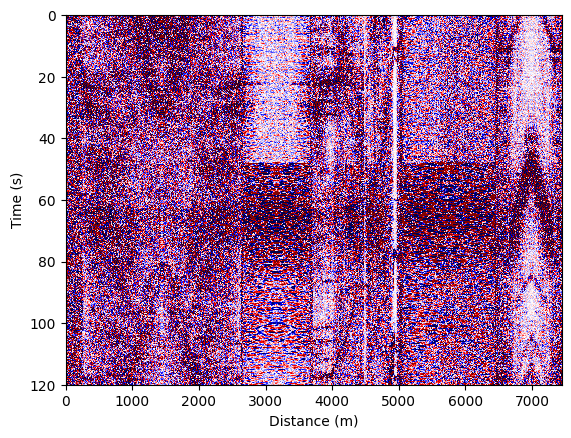

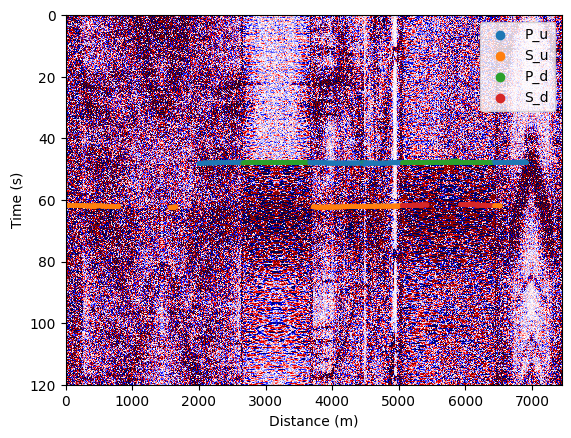

In [20]:
hdf5_filename = "MiDAS_good_72/test/MiDAS_20231029_012358.h5"
dir_nm = hdf5_filename.split('/')[0]
print_hdf5_contents(hdf5_filename)

ploting_new(hdf5_filename, dir_nm)

Dataset: data
(1824, 12001)
<KeysViewHDF5 ['begin_time', 'dt_s', 'dx_m', 'end_time', 'unit']>
[0.01, 4.084, 'microstrain/s']


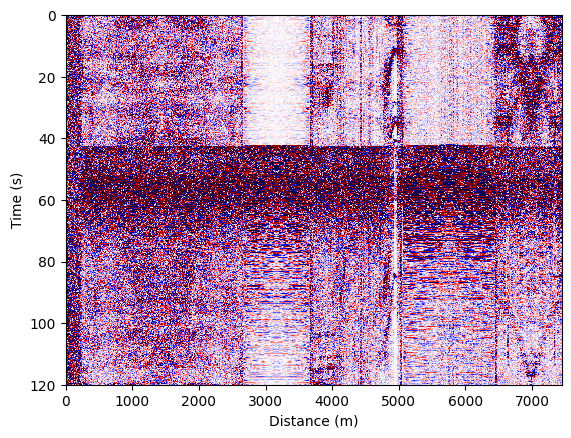

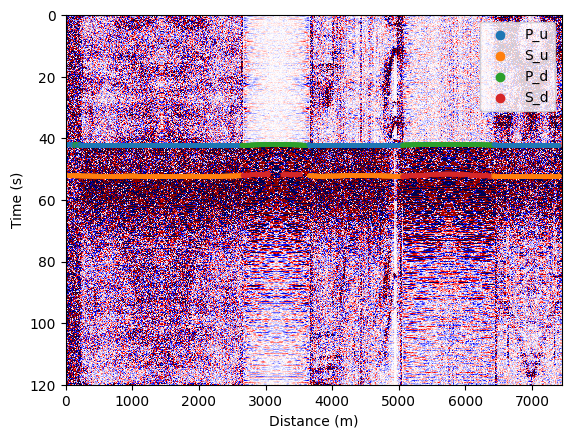

In [21]:
hdf5_filename = "MiDAS_good_72/test/MiDAS_20231223_023234.h5"
dir_nm = hdf5_filename.split('/')[0]
print_hdf5_contents(hdf5_filename)

ploting_new(hdf5_filename, dir_nm)

<font size = 6> Plotting training data </font>

In [ ]:
import os, glob

dir_name = 'MiDAS_good_72/train/'
hdf5_filelist = glob.glob(dir_name+'*.h5')

for k in range(len(hdf5_filelist)):
    
    hdf5_filename = hdf5_filelist[k]
    dir_nm = hdf5_filename.split('/')[0]
    ploting_new(hdf5_filename, dir_nm)

<font size = 6> Plotting test data </font>

In [ ]:
import os, glob

dir_name = 'MiDAS_good_72/test/'
#hdf5_filename = "MiDAS_good_72/test/MiDAS_20231223_023234.h5"
hdf5_filelist = glob.glob(dir_name+'*.h5')

for k in range(len(hdf5_filelist)):
    
    hdf5_filename = hdf5_filelist[k] #"MiDAS_good_72/test/MiDAS_20231223_023234.h5"
    dir_nm = hdf5_filename.split('/')[0]
    ploting_new(hdf5_filename, dir_nm)